# Analisis de complejidad Algoritmo Greedy - Tercera parte Cambios

In [12]:
from random import seed
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

In [13]:
# Seeds para que los resultados sean reproducibles
seed(20)
np.random.seed(20)

In [31]:
%%writefile util.py

from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

RUNS_PER_SIZE = 5
MAX_WORKERS = max((os.cpu_count() or 1) // 4, 1)

def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start

def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

Overwriting util.py


## Generacion de Datos
En esta sección, generamos 3 arreglos todos aleatoriamente en base al parametro que recibe la funcion. Los tableros generadon seran de tamaño $n x n$, demandas de filas, columnas y barcos seran un valor aleatorio entre 0 y $(n/2)$

In [32]:
%%writefile generador_datos.py

import random


def generador_datos(n):
    """
    Genera datos para un tablero de nxn con las nuevas restricciones.

    Args:
        n (int): Tamaño del tablero. Se usarán dimensiones de aproximadamente `n x n`.

    Returns:
        tuple: (filas, columnas, barcos)
    """
    demanda_filas = [random.randint(0, n // 2) for _ in range(n)]
    demanda_columnas = [random.randint(0, n // 2) for _ in range(n)]
    barcos = [random.randint(1, n // 2) for _ in range(random.randint(n // 2, n))]

    return demanda_filas, demanda_columnas, barcos



Overwriting generador_datos.py


In [33]:
%%writefile solucion_back_tracking.py

def solucion_backtracking(filas, columnas, barcos):
  ## Solucion bc
  return

Overwriting solucion_back_tracking.py


### Creación del Archivo con el Algoritmo de Solución Mediante Programación Dinámica

In [34]:
%%writefile solucion_greedy.py

def solucion_greedy(filas, columnas, barcos):
    barcos_ordenados = sorted(barcos, reverse=True)

    tablero = Tablero(filas, columnas)

    botesPuestos = 0

    while barcos_ordenados:
        largoBarco = barcos_ordenados.pop(0)
        (dimension, (demanda, indice)) = tablero.obtenerDimensionConMasDemanda()

        if demanda == 0:
            break


        if dimension == "Fila":
            tablero.posicionarHorizontalmente(indice, largoBarco, botesPuestos)
        else:
            tablero.posicionarVerticalmente(indice, largoBarco, botesPuestos)

        botesPuestos += 1

    return {
        'posiciones': tablero.ubicacionBotes,
        'demanda_cumplida': tablero.demandaCumplida,
        'demanda_total': tablero.demandaTotal
    }

class Tablero:
    def __init__(self, arrayFilas, arrayColumnas):
        self.filas = arrayFilas.copy()
        self.columnas = arrayColumnas.copy()
        self.matriz = [[0]*len(arrayFilas) for _ in range(len(arrayColumnas))]
        self.demandaCumplida = 0
        self.demandaTotal = sum(arrayFilas) + sum(arrayColumnas)
        self.ubicacionBotes = {}

    def obtenerDimensionConMasDemanda(self):
        dimensionMayor = ('Fila', (-1, -1))
        for idx, demandaFila in enumerate(self.filas):
            if demandaFila > dimensionMayor[1][0]:
                dimensionMayor = ('Fila', (demandaFila, idx))
        for idx, demandaColumna in enumerate(self.columnas):
            if demandaColumna > dimensionMayor[1][0]:
                dimensionMayor = ('Columna', (demandaColumna, idx))
        return dimensionMayor

    def posicionarHorizontalmente(self, numeroFila, tamanioBote, numeroBote):
        if tamanioBote > self.filas[numeroFila]:
            return False
        for x in range(0, len(self.columnas) - tamanioBote + 1):
            listaPosiciones = []
            flagFallo = False
            for y in range(x, x + tamanioBote):
                if (self.columnas[y] == 0 or
                    self.espacioEstaOcupado(numeroFila, y) or
                    self.hayBarcosAlrededor(numeroFila, y, len(self.filas), len(self.columnas))):
                    flagFallo = True
                    break
                listaPosiciones.append(y)

            if not flagFallo and listaPosiciones:
                for posicion in listaPosiciones:
                    self.columnas[posicion] -= 1
                    self.matriz[posicion][numeroFila] = "X"
                self.filas[numeroFila] -= tamanioBote
                self.demandaCumplida += (tamanioBote * 2)
                self.ubicacionBotes[numeroBote] = ((numeroFila, listaPosiciones[0]), (numeroFila, listaPosiciones[-1]))
                break

    def posicionarVerticalmente(self, numeroColumna, tamanioBote, numeroBote):
        if tamanioBote > self.columnas[numeroColumna]:
            return False
        for x in range(0, len(self.filas) - tamanioBote + 1):
            listaPosiciones = []
            flagFallo = False
            for y in range(x, x + tamanioBote):
                if (self.filas[y] == 0 or
                    self.espacioEstaOcupado(y, numeroColumna) or
                    self.hayBarcosAlrededor(y, numeroColumna, len(self.filas), len(self.columnas))):
                    flagFallo = True
                    break
                listaPosiciones.append(y)

            if not flagFallo and listaPosiciones:
                for posicion in listaPosiciones:
                    self.filas[posicion] -= 1
                    self.matriz[numeroColumna][posicion] = "X"
                self.columnas[numeroColumna] -= tamanioBote
                self.demandaCumplida += (tamanioBote * 2)
                self.ubicacionBotes[numeroBote] = ((listaPosiciones[0], numeroColumna), (listaPosiciones[-1], numeroColumna))
                break

    def hayBarcosAlrededor(self, fila, columna, numFilas, numColumnas):
        direcciones = [
            (1, 0), (-1, 0), (0, 1), (0, -1),
            (1, 1), (1, -1), (-1, 1), (-1, -1)
        ]

        for dx, dy in direcciones:
            nueva_fila = fila + dx
            nueva_columna = columna + dy

            if (0 <= nueva_fila < numFilas and
                0 <= nueva_columna < numColumnas and
                self.matriz[nueva_columna][nueva_fila] == "X"):
                return True
        return False

    def espacioEstaOcupado(self, fila, columna):
        return self.matriz[columna][fila] == "X"

Overwriting solucion_greedy.py


In [35]:
from util import time_algorithm
from solucion_back_tracking import solucion_backtracking
from solucion_greedy import solucion_greedy
from generador_datos import generador_datos

In [36]:
x = np.linspace(10, 300, 50).astype(int)

In [37]:
resultados_back_tracking = time_algorithm(solucion_backtracking, x, generador_datos)
resultados_greedy = time_algorithm(solucion_greedy, x, generador_datos)

## Medición y Visualización del Tiempo de Ejecución del Algoritmo
La solucion Greedy tiene una tendencia cuadratica con respecto al tamaño del tablero

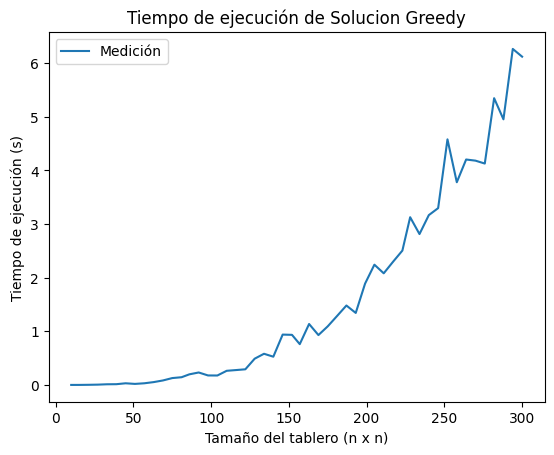

In [43]:
# Graficar los resultados
fig, ax = plt.subplots()
ax.plot(x, [resultados_greedy[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución de Solucion Greedy')
ax.set_xlabel('Tamaño del tablero (n x n)')
ax.set_ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.show()

### Ajuste de la Complejidad con un Modelo Cuadrático

Realizamos un ajuste de las mediciones usando un modelo cuadrático para comparar gráficos.

In [40]:
# modelo cuadrático para el ajuste
f = lambda x, c1, c2: c1 * x**2 + c2

results = resultados_greedy.copy()

# ajuste con mínimos cuadrados
c, pcov = sp.optimize.curve_fit(f, x, [results[n] for n in x])

print(f"c_1 = {c[0]}, c_2 = {c[1]}")
r = np.sum((f(x, *c) - [results[n] for n in x])**2)
print(f"Error cuadrático total: {r}")

c_1 = 6.495445365409776e-05, c_2 = -0.4136454038943244
Error cuadrático total: 6.597718550077678


Vemos que ajusta bastante bien al grafico por lo que se puede decir que el algoritmo greedy tiene complejidad $O(n^2)$

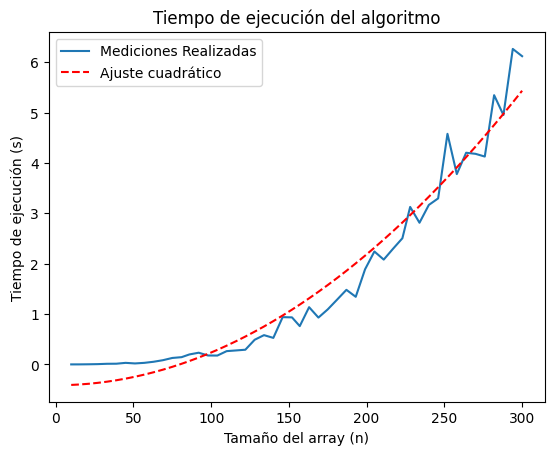

In [41]:
fig, ax = plt.subplots()
ax.plot(x, [results[n] for n in x], label="Mediciones Realizadas")
ax.plot(x, f(x, *c), 'r--', label="Ajuste cuadrático")
ax.set_title('Tiempo de ejecución del algoritmo')
ax.set_xlabel('Tamaño del array (n)')
ax.set_ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.show()

Tablero 30_25_25

In [ ]:
# Tablero 30_25_25
Demandas_filas = [3, 11, 11, 1, 2, 5, 4, 10, 5, 2, 12, 6, 12, 7, 0, 2, 0, 8, 10, 11, 6, 10, 0, 11, 5, 8, 6, 9, 8, 0]
Demandas_columnas = [3, 12, 1, 5, 14, 15, 6, 11, 2, 10, 12, 10, 6, 2, 7, 1, 5, 11, 5, 10, 7, 11, 4, 0, 5]
Barcos = [1, 1, 4, 4, 5, 6, 6, 6, 7, 8, 10, 10, 10, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 16, 16]